In [1]:
import pickle as pk
import pandas as pd
from tqdm import tqdm
from pymatgen.core.structure import Structure, Molecule
from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph
import numpy as np

In [2]:
data = pd.read_csv('data_all_new.csv')

molecules = []
targets = []

for i, row in tqdm(data.head(data.shape[0]).iterrows(), total=data.shape[0]):
    molecules.append(Molecule.from_str(row['xyz'], 'xyz'))
    targets.append(row['U_0'])

100%|██████████| 122381/122381 [00:59<00:00, 2057.92it/s]


In [16]:
molecules_train = molecules[:int(len(molecules)*0.9)]
targets_train = targets[:int(len(targets)*0.9)]

molecules_valid = molecules[int(len(molecules)*0.9):]
targets_valid = targets[int(len(targets)*0.9):]

In [24]:
nfeat_bond = 10
r_cutoff = 5
gaussian_centers = np.linspace(0, r_cutoff + 1, nfeat_bond)
gaussian_width = 0.5
graph_converter = CrystalGraph(cutoff=r_cutoff)
model = MEGNetModel(graph_converter=graph_converter, centers=gaussian_centers, width=gaussian_width)

# Model training
# Here, `structures` is a list of pymatgen Structure objects.
# `targets` is a corresponding list of properties.

In [25]:
model.train(molecules_train, targets_train, epochs=10)

Epoch 1/10
861/861 [==============================] - 599s 673ms/step - loss: 17234.3906
Epoch 2/10
861/861 [==============================] - 574s 667ms/step - loss: 925.5195
Epoch 3/10
861/861 [==============================] - 580s 674ms/step - loss: 645.6949
Epoch 4/10
861/861 [==============================] - 617s 716ms/step - loss: 453.9185
Epoch 5/10
861/861 [==============================] - 626s 727ms/step - loss: 326.6151
Epoch 6/10
861/861 [==============================] - 624s 724ms/step - loss: 249.3205
Epoch 7/10
861/861 [==============================] - 624s 724ms/step - loss: 227.1888
Epoch 8/10
861/861 [==============================] - 644s 748ms/step - loss: 186.5278
Epoch 9/10
861/861 [==============================] - 641s 745ms/step - loss: 174.1947
Epoch 10/10
861/861 [==============================] - 645s 750ms/step - loss: 168.2667


In [26]:
y_pred = []
y_true = []
mae = 0

for i in tqdm(range(len(molecules_valid))):
    prediction = model.predict_structure(molecules_valid[i])
    y_pred.append(prediction)
    true_value = targets_valid[i]
    y_true.append(true_value)
    mae += abs(true_value - prediction)
mae /= len(molecules_valid)
mae

100%|██████████| 12239/12239 [14:17<00:00, 14.28it/s] 


array([6.0701847], dtype=float32)

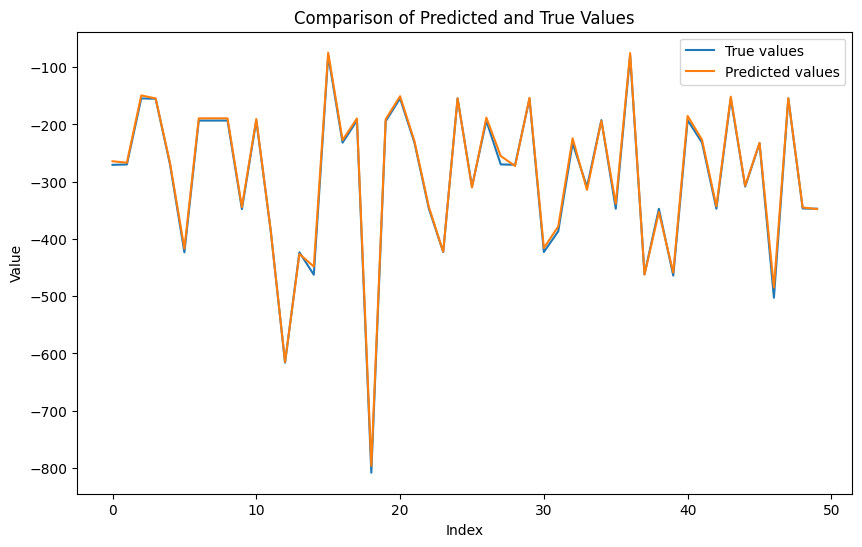

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_true[:50], label='True values')
plt.plot(y_pred[:50], label='Predicted values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Predicted and True Values')
plt.legend();

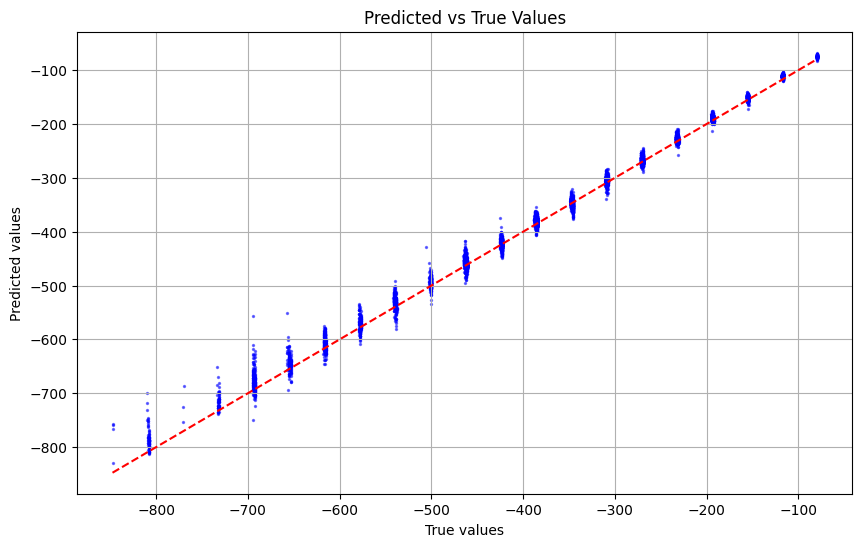

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, color='b', alpha=0.5, s=2) 
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='r', linestyle='--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs True Values')
plt.grid(True)

In [29]:
model.save_model('10_e_default.hdf5')

In [18]:
model = MEGNetModel(graph_converter=graph_converter, centers=gaussian_centers, width=gaussian_width)
graphs_valid = []
targets_valid = []
structures_invalid = []
for s, p in zip(molecules, targets):
    try:
        graph = model.graph_converter.convert(s)
        graphs_valid.append(graph)
        targets_valid.append(p)
    except:
        structures_invalid.append(s)

# train the model using valid graphs and targets
model.train_from_graphs(graphs_valid, targets_valid, epochs=10)

Epoch 1/10
8/8 [==============================] - 21s 340ms/step - loss: 119846.7109
Epoch 2/10
8/8 [==============================] - 3s 340ms/step - loss: 119253.7344
Epoch 3/10
8/8 [==============================] - 3s 346ms/step - loss: 85360.1094
Epoch 4/10
8/8 [==============================] - 3s 346ms/step - loss: 672155.0000
Epoch 5/10
8/8 [==============================] - 3s 331ms/step - loss: 109076.1016
Epoch 6/10
8/8 [==============================] - 3s 337ms/step - loss: 30412.1992
Epoch 7/10
8/8 [==============================] - 3s 352ms/step - loss: 25225.9336
Epoch 8/10
8/8 [==============================] - 3s 334ms/step - loss: 23487.7695
Epoch 9/10
8/8 [==============================] - 3s 350ms/step - loss: 21019.4512
Epoch 10/10
8/8 [==============================] - 3s 365ms/step - loss: 19996.2676
